## Training with Chainer

[VGG](https://arxiv.org/pdf/1409.1556v6.pdf) is an architecture for deep convolution networks. In this example, we train a convolutional network to perform image classification using the CIFAR-10 dataset. CIFAR-10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. We'll train a model on SageMaker, deploy it to Amazon SageMaker, and then classify images using the deployed model.

The Chainer script runs inside of a Docker container running on SageMaker. For more on the Chainer container, please visit the sagemaker-chainer-containers repository and the sagemaker-python-sdk repository:

* https://github.com/aws/sagemaker-chainer-containers
* https://github.com/aws/sagemaker-python-sdk

In [1]:
# Setup
from sagemaker import get_execution_role
import sagemaker

sagemaker_session = sagemaker.Session()

# This role retrieves the SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

## Downloading training and test data

We use helper functions given by `chainer` to download and preprocess the CIFAR10 data. 

In [2]:
import chainer

from chainer.datasets import get_cifar10

train, test = get_cifar10()

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Uploading the data

We save the preprocessed data to the local filesystem, and then use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the S3 location, which we will use when we start the Training Job.

In [3]:
import os
import shutil

import numpy as np

train_data = [element[0] for element in train]
train_labels = [element[1] for element in train]

test_data = [element[0] for element in test]
test_labels = [element[1] for element in test]


try:
    os.makedirs('/tmp/data/train_cifar')
    os.makedirs('/tmp/data/test_cifar')
    np.savez('/tmp/data/train_cifar/train.npz', data=train_data, labels=train_labels)
    np.savez('/tmp/data/test_cifar/test.npz', data=test_data, labels=test_labels)
    train_input = sagemaker_session.upload_data(path=os.path.join('/tmp', 'data', 'train_cifar'),
                                                            key_prefix='notebook/chainer_cifar/train')
    test_input = sagemaker_session.upload_data(path=os.path.join('/tmp', 'data', 'test_cifar'),
                                                           key_prefix='notebook/chainer_cifar/test')
finally:
    shutil.rmtree('/tmp/data')
print(train_input)

s3://sagemaker-us-west-2-142577830533/notebook/chainer_cifar/train


## Writing the Chainer training script to run on Amazon SageMaker

We need to provide a training script that can run on the SageMaker platform. The training scripts are essentially the same as one you would write for local training, except that you need to provide a function `train` that returns a trained `chainer.Chain`.

Since we will use the same script to host the Chainer model, the script also needs a function `model_fn` that loads a Chainer Model. When SageMaker calls your `train` and `model_fn` functions, it will pass in arguments that describe the training environment.

While the `train` and `model_fn` functions are required, the Chainer container provides default implementations for a few other functions. The function hooks recognized by the container are listed below, with required functions in bold:

### Training

* **`train`**: This function is passed arguments read from the Training Job's environment and returns a trained model. Files written to `model_dir` are compressed and uploaded to S3 at the end of training.
  `train` can accept the following arguments by name:
  * `hyperparameters (dict)`: The hyperparameters map passed from the SageMaker Python SDK.
  * `num_gpus (int)`: The number of GPUs available to the host.
  * `output_data_dir (str)`: The filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3.
  * `channel_input_dirs (dict of str: str)`: A map of input channel names (like 'train' and 'test') to filesystem paths to data in those input channels. 
  * `model_dir (str)`: path to the directory to write model artifacts to.
  
  For more on the arguments to `train` and others, please visit https://github.com/aws/sagemaker-containers.
  

### Hosting and Inference

* **`model_fn(model_dir)`**: This function is invoked to load model artifacts from those written into `model_dir` during training.
* `input_fn(input_data, content_type)`: This function is invoked to deserialize prediction data when a prediction request is made. The return value is passed to predict_fn. `input_fn` accepts two arguments: `input_data`, which is the serialized input data in the body of the prediction request, and `content_type`, the MIME type of the data
  
  
* `predict_fn(input_data, model)`: This function accepts the return value of `input_fn` (as `input_data`) and the return value of `model_fn`, `model`, and returns inferences obtained from the model
  
  
* `output_fn(prediction, accept)`: This function is invoked to serialize the return value from `predict_fn`, passed in via `prediction`, back to the SageMaker client in response to prediction requests

Check the script below, which uses `chainer` to train on any number of GPUs on a single machine, to see how this works. This script implements `train`, for training, and `model_fn`, and `predict_fn` for hosting, but relies on the default `input_fn` and `output_fn`.

For more on implementing these functions, see the documentation at https://github.com/aws/sagemaker-python-sdk.

For more on the functions provided by the Chainer container, see https://github.com/aws/sagemaker-chainer-containers

In [4]:
!cat 'code/chainer_cifar_vgg_single_machine.py'

# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

from __future__ import print_function, absolute_import

import os

import numpy as np

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer import serializers
from chainer.training import extensions

import net


def train(hyperparameters, num_gpus, output_data_dir, channel_input_dirs, model_dir):
    """
    This function is called by the Chainer container during trainin

## Running the training script on SageMaker

To train with a Chainer script, we construct a ```Chainer``` estimator using the [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk). We pass in an `entry_point`, the name of a script that contains a couple of functions with certain signatures (`train` and `model_fn`), and a `source_dir`, a directory containing all code to run inside the Chainer container. This script will be run on SageMaker in a container that invokes these functions to train and load Chainer models. 

The ```Chainer``` class allows us to run our training function as a training job on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. In this case we will run our training job on one `ml.p3.2xlarge` instance.

In [5]:
from sagemaker.chainer.estimator import Chainer

chainer_estimator = Chainer(entry_point='chainer_cifar_vgg_single_machine.py', source_dir="code", role=role,
                            sagemaker_session=sagemaker_session,
                            train_instance_count=1, train_instance_type='ml.p3.2xlarge',
                            hyperparameters={'epochs': 50, 'batch_size': 64})

chainer_estimator.fit({'train': train_input, 'test': test_input})

INFO:sagemaker:Creating training-job with name: sagemaker-chainer-2018-05-18-22-56-25-482


.......................
2018-05-18 23:00:03,381 INFO - root - running container entrypoint
2018-05-18 23:00:03,381 INFO - root - starting train task
2018-05-18 23:00:03,393 INFO - container_support.app - started training: {'train_fn': <function train at 0x7fab61b74bf8>}
2018-05-18 23:00:03,493 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.170.2
2018-05-18 23:00:03,568 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-142577830533.s3.amazonaws.com
2018-05-18 23:00:03,614 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (2): sagemaker-us-west-2-142577830533.s3.amazonaws.com
2018-05-18 23:00:03,629 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-142577830533.s3.us-west-2.amazonaws.com
2018-05-18 23:00:03,687 INFO - botocore.vendored

Our Chainer script writes various artifacts, such as plots, to a directory `output_data_dir`, the contents of which which SageMaker uploads to S3. Now we download and extract these artifacts.

In [6]:
from s3_util import retrieve_output_from_s3

chainer_training_job = chainer_estimator.latest_training_job.name

desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=chainer_training_job)
output_data = desc['ModelArtifacts']['S3ModelArtifacts'].replace('model.tar.gz', 'output.tar.gz')

retrieve_output_from_s3(output_data, 'output/single_machine_cifar')

These plots show the accuracy and loss over epochs:

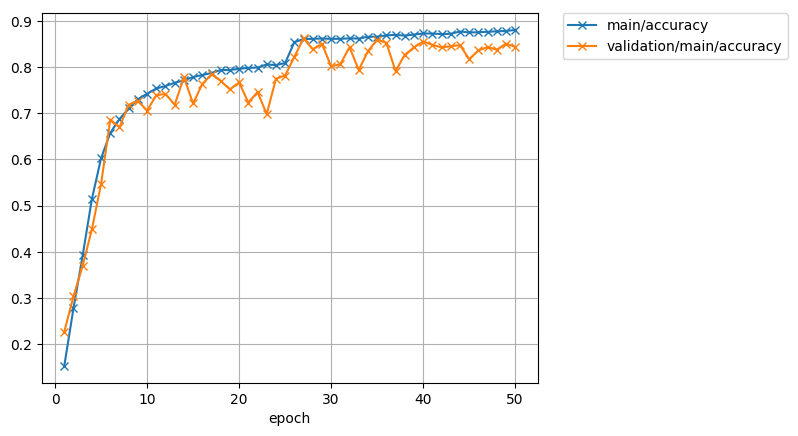

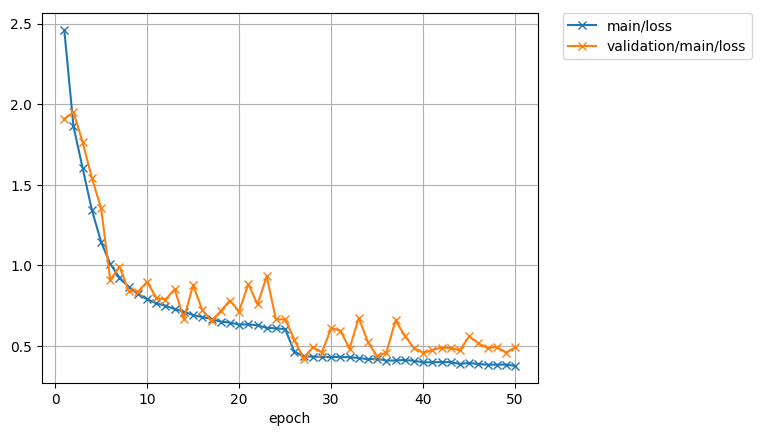

In [7]:
from IPython.display import Image
from IPython.display import display

accuracy_graph = Image(filename = "output/single_machine_cifar/accuracy.png", width=800, height=800)
loss_graph = Image(filename = "output/single_machine_cifar/loss.png", width=800, height=800)

display(accuracy_graph, loss_graph)

## Deploying the Trained Model

After training, we use the Chainer estimator object to create and deploy a hosted prediction endpoint. We can use a CPU-based instance for inference (in this case an `ml.m4.xlarge`), even though we trained on GPU instances.

The predictor object returned by `deploy` lets us call the new endpoint and perform inference on our sample images. 

In [8]:
predictor = chainer_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-chainer-2018-05-18-22-56-25-482
INFO:sagemaker:Creating endpoint with name sagemaker-chainer-2018-05-18-22-56-25-482


---------------------------------------------------------------------------!

### CIFAR10 sample images

We'll use these CIFAR10 sample images to test the service:

<img style="display: inline; height: 32px; margin: 0.25em" src="images/airplane1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/automobile1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/bird1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/cat1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/deer1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/dog1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/frog1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/horse1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/ship1.png" />
<img style="display: inline; height: 32px; margin: 0.25em" src="images/truck1.png" />



## Predicting using SageMaker Endpoint

We batch the images together into a single NumPy array to obtain multiple inferences with a single prediction request.

In [9]:
from skimage import io
import numpy as np

def read_image(filename):
    img = io.imread(filename)
    img = np.array(img).transpose(2, 0, 1)
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32)
    img *= 1. / 255.
    img = img.reshape(3, 32, 32)
    return img


def read_images(filenames):
    return np.array([read_image(f) for f in filenames])

filenames = ['images/airplane1.png',
             'images/automobile1.png',
             'images/bird1.png',
             'images/cat1.png',
             'images/deer1.png',
             'images/dog1.png',
             'images/frog1.png',
             'images/horse1.png',
             'images/ship1.png',
             'images/truck1.png']

image_data = read_images(filenames)

The predictor runs inference on our input data and returns a list of predictions whose argmax gives the predicted label of the input data. 

In [10]:
response = predictor.predict(image_data)

for i, prediction in enumerate(response):
    print('image {}: prediction: {}'.format(i, prediction.argmax(axis=0)))

image 0: prediction: 0
image 1: prediction: 1
image 2: prediction: 2
image 3: prediction: 3
image 4: prediction: 4
image 5: prediction: 5
image 6: prediction: 6
image 7: prediction: 7
image 8: prediction: 8
image 9: prediction: 9


## Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [11]:
chainer_estimator.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: sagemaker-chainer-2018-05-18-22-56-25-482
